# TECHIN 513 - Final Project
# Floor Hazard Detection for Robots

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# For signal processing
import scipy.signal as signal
import scipy.fftpack as fft
from scipy.stats import skew, kurtosis

# For machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
np.random.seed(42)
tf.random.set_seed(42)


drive.mount('/content/drive')
data_path = "/content/drive/My Drive/MDSP_FinalProject/RawData"

Mounted at /content/drive


# DATA LOADING

Loading data from /content/drive/My Drive/MDSP_FinalProject/RawData
Found 39 CSV files
Loaded 1.csv: 3090 rows, 5 columns
Loaded only wire acceleration_2025-03-06_15-29-55.csv: 1177 rows, 5 columns
Loaded only bumpacceleration_2025-03-06_15-30-48.csv: 1655 rows, 5 columns
Loaded smooth_w_acceleration_2025-03-06_15-31-36.csv: 1448 rows, 5 columns
Loaded w_wire only acceleration_2025-03-06_15-32-21.csv: 1244 rows, 5 columns
Loaded only bump 2 acceleration_2025-03-06_15-33-09.csv: 1537 rows, 5 columns
Loaded w_smooth opposite direction acceleration_2025-03-06_15-33-44.csv: 1117 rows, 5 columns
Loaded w direction 2 bump only acceleration_2025-03-06_15-34-43.csv: 1477 rows, 5 columns
Loaded bump only direction opposite acceleration_2025-03-06_15-35-24.csv: 1566 rows, 5 columns
Loaded floor w acceleration_2025-03-06_15-39-42.csv: 1342 rows, 5 columns
Loaded floor bump 1 w acceleration_2025-03-06_15-42-40.csv: 1463 rows, 5 columns
Loaded floor bump 2 w acceleration_2025-03-06_15-43-40.csv: 15

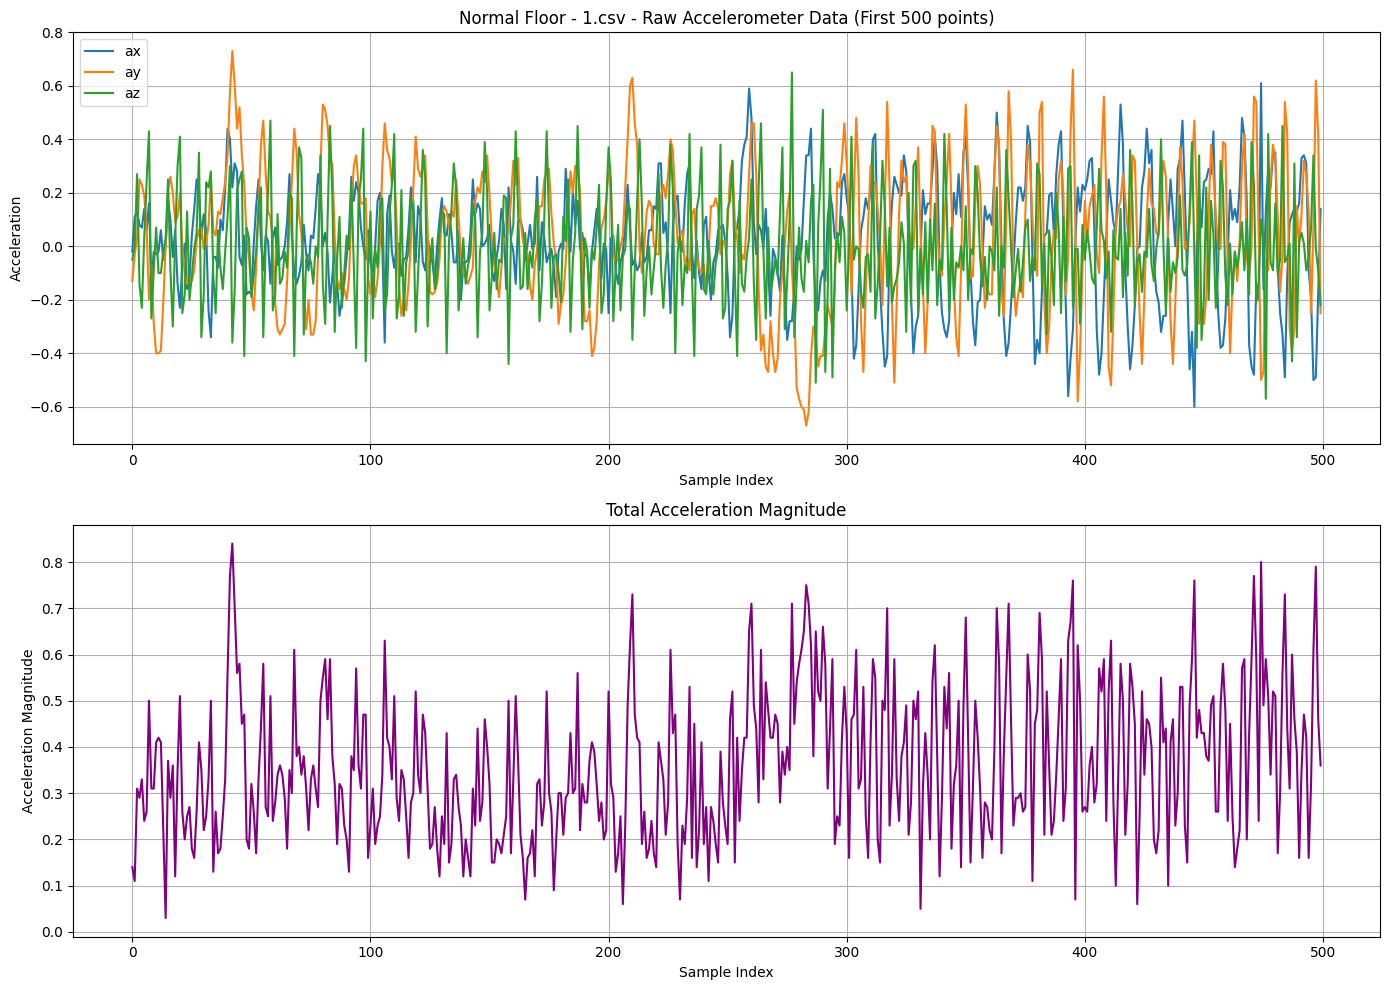

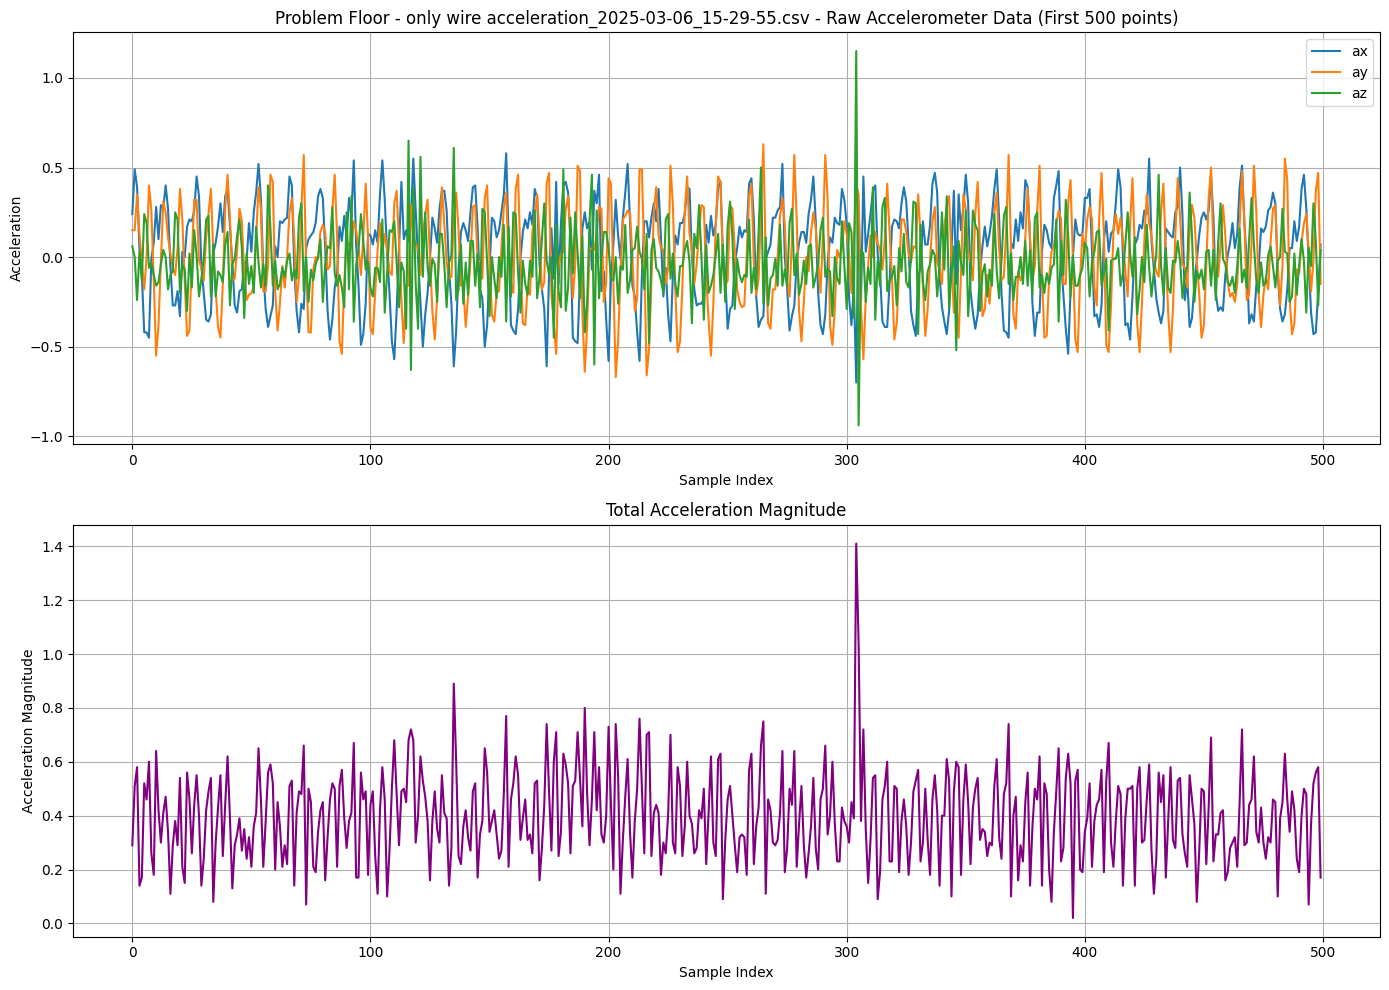

In [18]:
def load_data(data_path):
    print(f"Loading data from {data_path}")
    csv_files = glob.glob(os.path.join(data_path, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {data_path}")
        return {}

    print(f"Found {len(csv_files)} CSV files")
    dataframes = {}

    for file in csv_files:
        file_name = os.path.basename(file)
        try:
            df = pd.read_csv(file)

            if not {'ax', 'ay', 'az'}.issubset(df.columns):
                print(f"Warning: File {file_name} missing expected accelerometer columns")
            else:

                if 'atotal' not in df.columns:
                    df['atotal'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)

                dataframes[file_name] = df
                print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
        except Exception as e:
            print(f"Error loading {file_name}: {str(e)}")

    return dataframes


dataframes = load_data(data_path)

if not dataframes:

    print("No data found. Creating synthetic test data.")


    num_files = 39
    sample_length = 1000


    for i in range(num_files):
        is_problem = i >= num_files / 2
        base_freq = 5
        base_amp = 0.5


        t = np.linspace(0, 10, sample_length)

        if not is_problem:
            ax = base_amp * np.sin(2 * np.pi * base_freq * t) + 0.1 * np.random.randn(sample_length)
            ay = base_amp * np.sin(2 * np.pi * base_freq * t + np.pi/4) + 0.1 * np.random.randn(sample_length)
            az = base_amp * np.sin(2 * np.pi * base_freq * t + np.pi/2) + 0.1 * np.random.randn(sample_length)
            file_name = f"normal_floor_{i+1}.csv"

        else:

            ax = base_amp * np.sin(2 * np.pi * base_freq * t) + 0.3 * np.sin(2 * np.pi * 15 * t) + 0.3 * np.random.randn(sample_length)
            ay = base_amp * np.sin(2 * np.pi * base_freq * t + np.pi/4) + 0.3 * np.sin(2 * np.pi * 20 * t) + 0.3 * np.random.randn(sample_length)
            az = base_amp * np.sin(2 * np.pi * base_freq * t + np.pi/2) + 0.3 * np.sin(2 * np.pi * 25 * t) + 0.3 * np.random.randn(sample_length)


            for _ in range(5):
                spike_loc = np.random.randint(0, sample_length)
                spike_width = np.random.randint(5, 20)
                spike_amp = np.random.uniform(1.5, 3.0)

                if spike_loc + spike_width < sample_length:
                    ax[spike_loc:spike_loc+spike_width] += spike_amp
                    ay[spike_loc:spike_loc+spike_width] += spike_amp
                    az[spike_loc:spike_loc+spike_width] += spike_amp

            problem_types = ["debris", "crack", "bump", "gap", "wire"]
            problem_type = problem_types[i % len(problem_types)]
            file_name = f"floor_with_{problem_type}_{i+1}.csv"


        atotal = np.sqrt(ax**2 + ay**2 + az**2)
        df = pd.DataFrame({
            'timestamp': pd.date_range(start='2025-03-01', periods=sample_length, freq='10ms'),
            'ax': ax,
            'ay': ay,
            'az': az,
            'atotal': atotal
        })
        dataframes[file_name] = df


print(f"\nLoaded {len(dataframes)} datasets")
file_names = list(dataframes.keys())


def visualize_raw_data(df, title="Accelerometer Data"):
    plt.figure(figsize=(14, 10))

    # raw accelerometer
    plt.subplot(2, 1, 1)
    for col in ['ax', 'ay', 'az']:
        if col in df.columns:
            plt.plot(df.index[:500], df[col][:500], label=col)
    plt.title(f"{title} - Raw Accelerometer Data (First 500 points)")
    plt.xlabel("Sample Index")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.grid(True)

    # total acceleration
    plt.subplot(2, 1, 2)
    if 'atotal' in df.columns:
        plt.plot(df.index[:500], df['atotal'][:500], color='purple')
        plt.title("Total Acceleration Magnitude")
        plt.xlabel("Sample Index")
        plt.ylabel("Acceleration Magnitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


if len(file_names) >= 2:
    normal_file = next((f for f in file_names if "normal" in f.lower()), file_names[0])
    problem_file = next((f for f in file_names if any(x in f.lower() for x in ["debris", "crack", "bump", "gap", "wire"])), file_names[-1])

    visualize_raw_data(dataframes[normal_file], f"Normal Floor - {normal_file}")
    visualize_raw_data(dataframes[problem_file], f"Problem Floor - {problem_file}")

# SIGNAL PROCESSING (FEATURE EXTRACTION)


Extracted 80 features from 39 datasets

Class distribution:
label
1    27
0    12
Name: count, dtype: int64


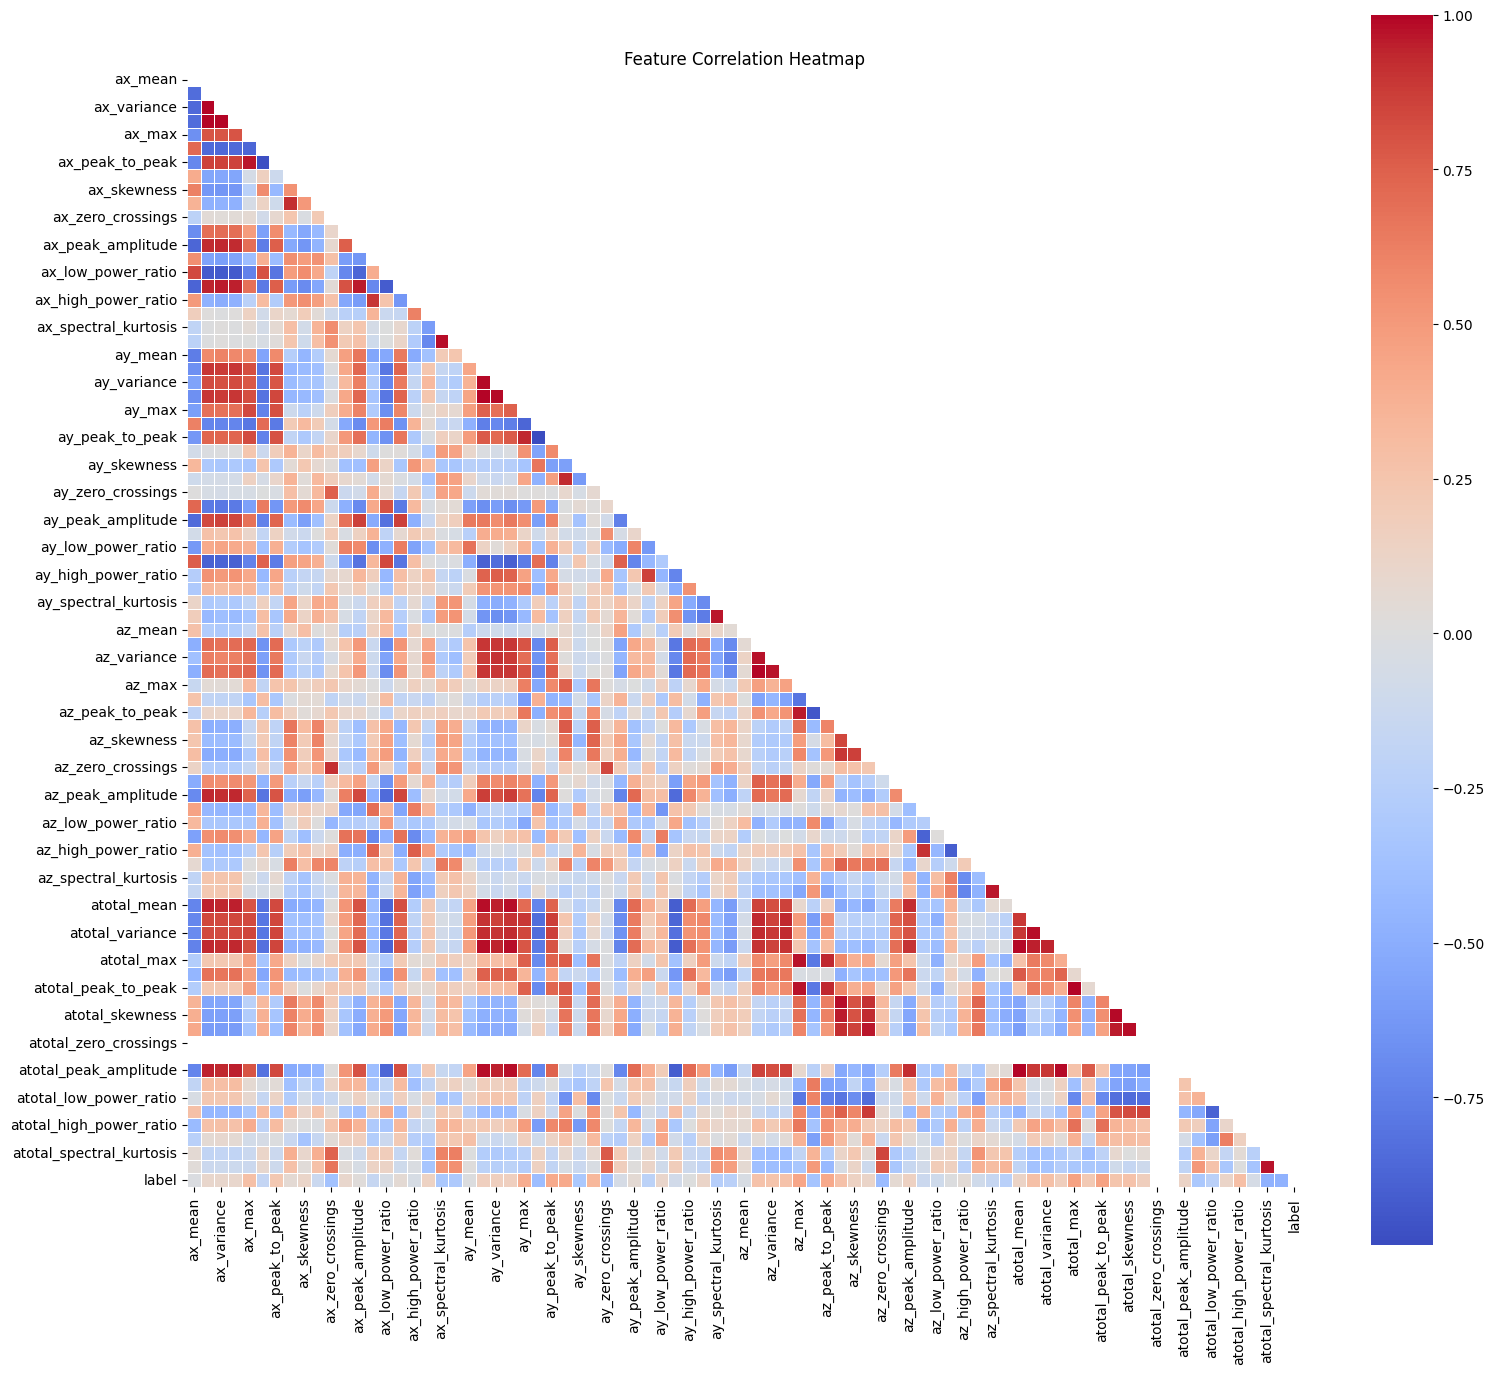

In [19]:
def plot_spectrum(signal_data, fs=100, title="Frequency Spectrum"):
    N = len(signal_data)
    T = 1.0 / fs
    yf = fft.fft(signal_data)
    xf = fft.fftfreq(N, T)[:N//2]

    plt.figure(figsize=(10, 5))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

def extract_time_domain_features(data):
    return {
        'mean': np.mean(data),
        'std': np.std(data),
        'variance': np.var(data),
        'rms': np.sqrt(np.mean(np.square(data))),
        'max': np.max(data),
        'min': np.min(data),
        'peak_to_peak': np.max(data) - np.min(data),
        'crest_factor': np.max(np.abs(data)) / np.sqrt(np.mean(np.square(data))) if np.mean(np.square(data)) > 0 else 0,
        'skewness': skew(data),
        'kurtosis': kurtosis(data),
        'zero_crossings': np.sum(np.diff(np.signbit(data).astype(int)) != 0),
    }

def extract_frequency_domain_features(data, fs=100):
    N = len(data)
    T = 1.0 / fs
    yf = fft.fft(data)
    xf = fft.fftfreq(N, T)[:N//2]
    amplitude_spectrum = 2.0/N * np.abs(yf[:N//2])

    # Find dominant frequencies
    peaks, _ = signal.find_peaks(amplitude_spectrum, height=0.1*np.max(amplitude_spectrum))


    low_mask = (xf >= 0) & (xf < 10)
    mid_mask = (xf >= 10) & (xf < 30)
    high_mask = (xf >= 30) & (xf < 50)

    low_power = np.sum(amplitude_spectrum[low_mask]**2)
    mid_power = np.sum(amplitude_spectrum[mid_mask]**2)
    high_power = np.sum(amplitude_spectrum[high_mask]**2)
    total_power = np.sum(amplitude_spectrum**2)

    if np.sum(amplitude_spectrum) > 0:
        spectral_centroid = np.sum(xf * amplitude_spectrum) / np.sum(amplitude_spectrum)
    else:
        spectral_centroid = 0

    return {
        'dominant_freq': xf[np.argmax(amplitude_spectrum)] if len(amplitude_spectrum) > 0 else 0,
        'peak_amplitude': np.max(amplitude_spectrum) if len(amplitude_spectrum) > 0 else 0,
        'spectral_centroid': spectral_centroid,
        'low_power_ratio': low_power / total_power if total_power > 0 else 0,
        'mid_power_ratio': mid_power / total_power if total_power > 0 else 0,
        'high_power_ratio': high_power / total_power if total_power > 0 else 0,
        'num_peaks': len(peaks),
        'spectral_kurtosis': kurtosis(amplitude_spectrum) if len(amplitude_spectrum) > 0 else 0,
        'spectral_skewness': skew(amplitude_spectrum) if len(amplitude_spectrum) > 0 else 0,
    }

def extract_features_from_df(df, fs=100):
    features = {}

    # Loop through each axis
    for axis in ['ax', 'ay', 'az', 'atotal']:
        if axis in df.columns:

            time_features = extract_time_domain_features(df[axis].values)
            for key, value in time_features.items():
                features[f"{axis}_{key}"] = value


            freq_features = extract_frequency_domain_features(df[axis].values, fs=fs)
            for key, value in freq_features.items():
                features[f"{axis}_{key}"] = value

    return features

# Extract features from ALL datasets
def process_all_datasets(dataframes):
    features_list = []

    for file_name, df in dataframes.items():
        try:

            features = extract_features_from_df(df)


            features['file_name'] = file_name
            features['label'] = int(any(keyword in file_name.lower() for keyword in
                                   ["bump", "crack", "debris", "gap", "wire", "problem"]))

            features_list.append(features)
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")

    features_df = pd.DataFrame(features_list)

    return features_df

features_df = process_all_datasets(dataframes)

# features summary
print(f"\nExtracted {features_df.shape[1]-2} features from {features_df.shape[0]} datasets")
print("\nClass distribution:")
print(features_df['label'].value_counts())


plt.figure(figsize=(16, 14))
numeric_features = features_df.select_dtypes(include=[np.number]).columns
correlation = features_df[numeric_features].corr()


mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', linewidths=.5, fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

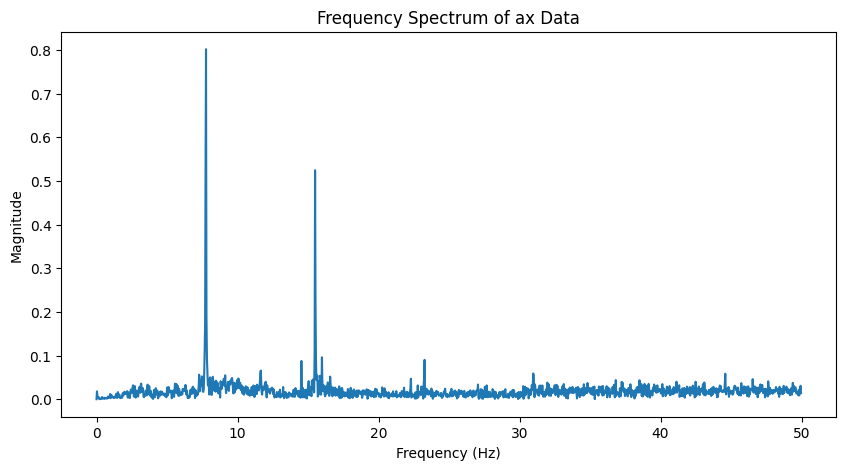

# MACHINE LEARNING

Training data shape: (31, 80)
Testing data shape: (8, 80)

 SVM Model 
Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Test Accuracy: 0.8750
SVM Precision: 0.8571
SVM Recall: 1.0000
SVM F1 Score: 0.9231

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8



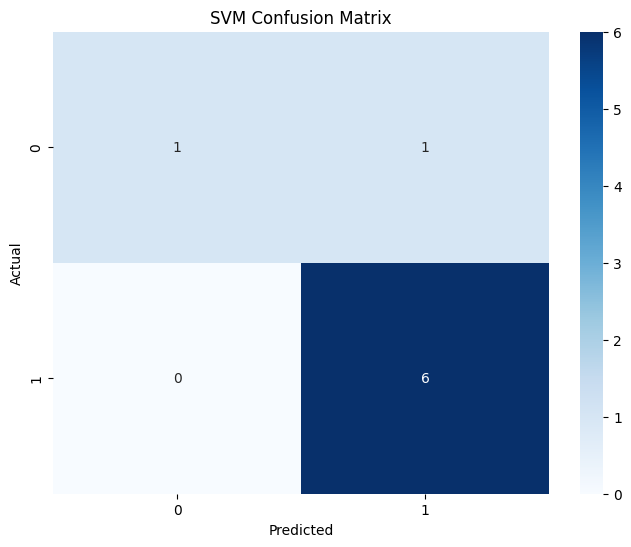

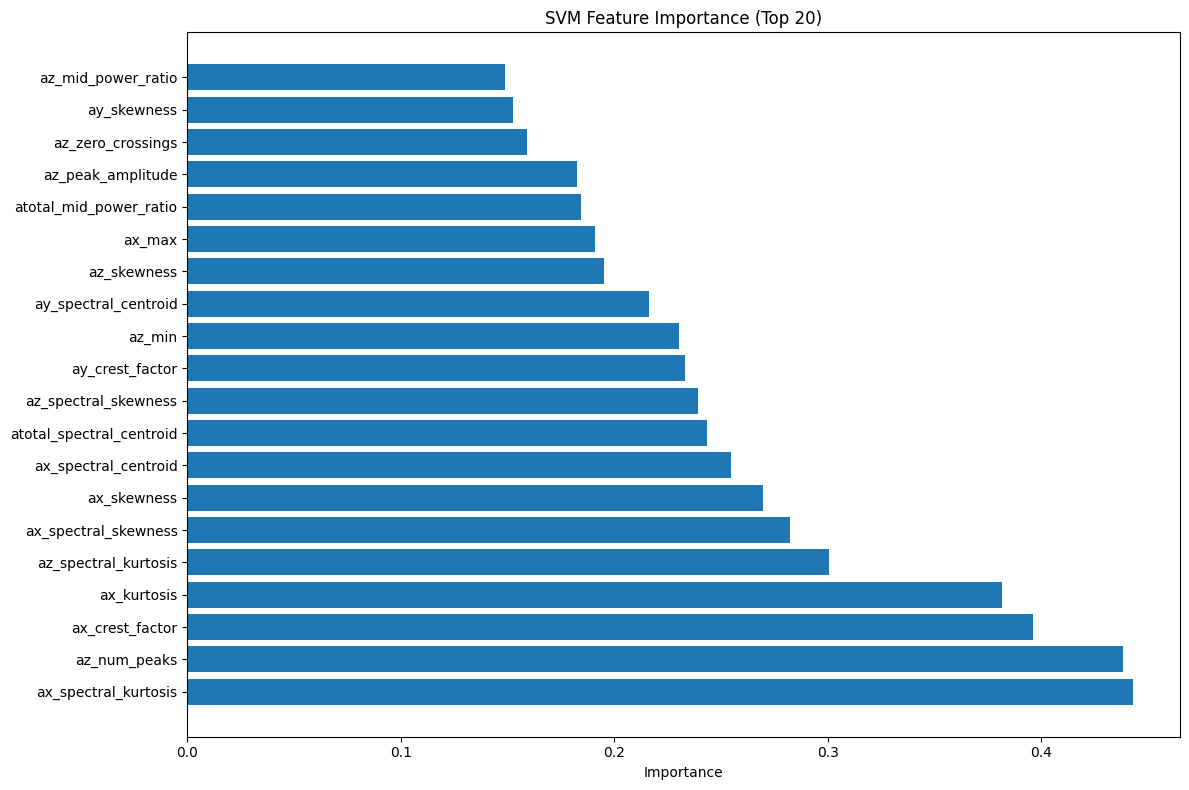

In [20]:
def prepare_data_for_ml(features_df):
    X = features_df.drop(['file_name', 'label'], axis=1)
    y = features_df['label']
    X = X.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training data shape: {X_train_scaled.shape}")
    print(f"Testing data shape: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns


X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names = prepare_data_for_ml(features_df)

# SVM Model
def train_svm_model(X_train, y_train, X_test, y_test):
    print("\n SVM Model ")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearch
    grid_search = GridSearchCV(
        SVC(probability=True, random_state=42),
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)


    best_svm = grid_search.best_estimator_
    print(f"Best SVM parameters: {grid_search.best_params_}")

    # Evaluation
    y_pred_svm = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_svm)
    precision = precision_score(y_test, y_pred_svm)
    recall = recall_score(y_test, y_pred_svm)
    f1 = f1_score(y_test, y_pred_svm)

    print(f"SVM Test Accuracy: {accuracy:.4f}")
    print(f"SVM Precision: {precision:.4f}")
    print(f"SVM Recall: {recall:.4f}")
    print(f"SVM F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_svm))

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature importance
    if best_svm.kernel == 'linear':
        importance = np.abs(best_svm.coef_[0])
        indices = np.argsort(importance)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title('SVM Feature Importance (Top 20)')
        plt.barh(range(20), importance[indices][:20], align='center')
        plt.yticks(range(20), [feature_names[i] for i in indices][:20])
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

    return best_svm, accuracy, precision, recall, f1


svm_model, svm_accuracy, svm_precision, svm_recall, svm_f1 = train_svm_model(
    X_train_scaled, y_train, X_test_scaled, y_test
)



 Deep Learning Model
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2581 - loss: 1.2338 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4839 - loss: 1.0450 - val_accuracy: 0.3750 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4516 - loss: 0.9293 - val_accuracy: 0.3750 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5161 - loss: 0.8602 - val_accuracy: 0.3750 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5806 - loss: 0.7464 - val_accuracy: 0.3750 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7097 - loss: 0.5874 - val_accuracy: 0.5000 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7419 - loss: 0.5142 - val_accuracy: 0.5000 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Deep Learning Test Accuracy: 0.7500
Deep Learning Precision: 0.7500
Deep Learning Recall: 1.0000
Deep Learning F1 Score: 0.8571

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


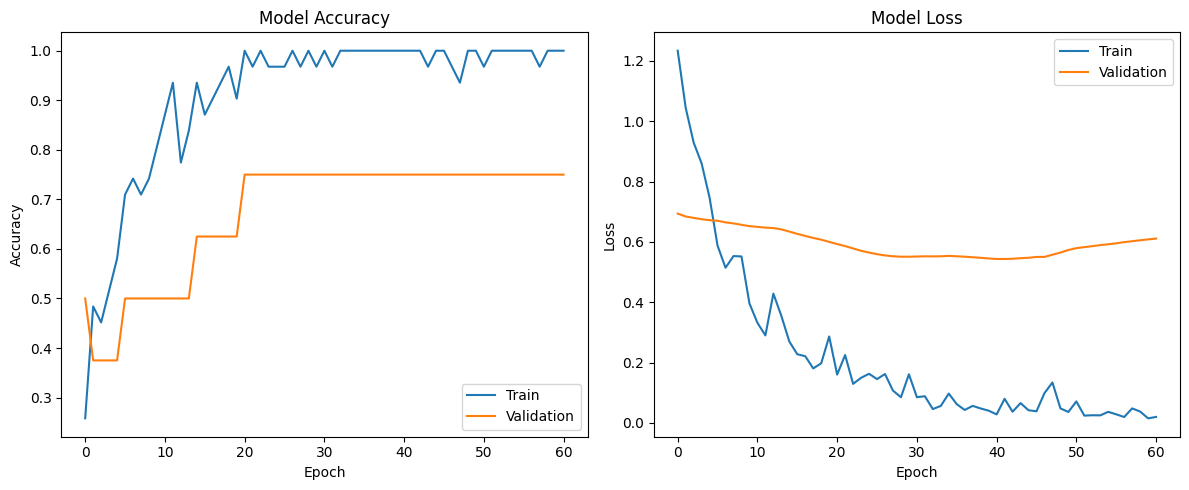

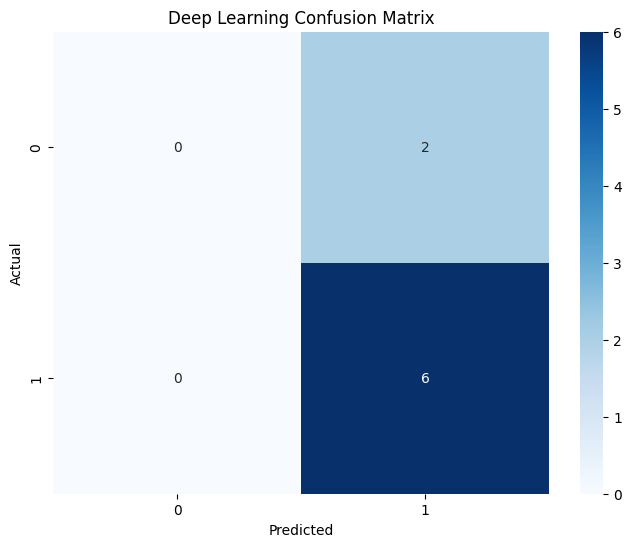

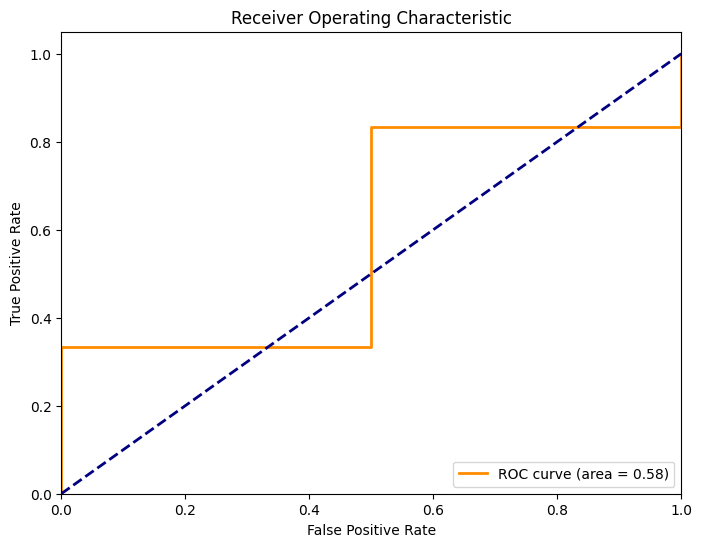

In [22]:
# Deep Learning Model
def build_and_train_dl_model(X_train, y_train, X_test, y_test):
    print("\n Deep Learning Model")


    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat = to_categorical(y_test, num_classes=2)


    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])


    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )


    history = model.fit(
        X_train, y_train_cat,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, y_test_cat),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Deep Learning Test Accuracy: {accuracy:.4f}")
    print(f"Deep Learning Precision: {precision:.4f}")
    print(f"Deep Learning Recall: {recall:.4f}")
    print(f"Deep Learning F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Deep Learning Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return model, history, accuracy, precision, recall, f1

dl_model, dl_history, dl_accuracy, dl_precision, dl_recall, dl_f1 = build_and_train_dl_model(
    X_train_scaled, y_train, X_test_scaled, y_test
)

# 4. ABLATION STUDY


  Ablation Study 
Subset: All Features, Features: 80, Accuracy: 0.7500, F1: 0.8571
Subset: Time Domain Only, Features: 56, Accuracy: 0.7500, F1: 0.8571
Subset: Frequency Domain Only, Features: 36, Accuracy: 0.7500, F1: 0.8571
Subset: X-Axis Only, Features: 20, Accuracy: 0.7500, F1: 0.8571
Subset: Y-Axis Only, Features: 20, Accuracy: 0.7500, F1: 0.8571
Subset: Z-Axis Only, Features: 20, Accuracy: 0.7500, F1: 0.8571
Subset: Total Acceleration Only, Features: 20, Accuracy: 0.7500, F1: 0.8571


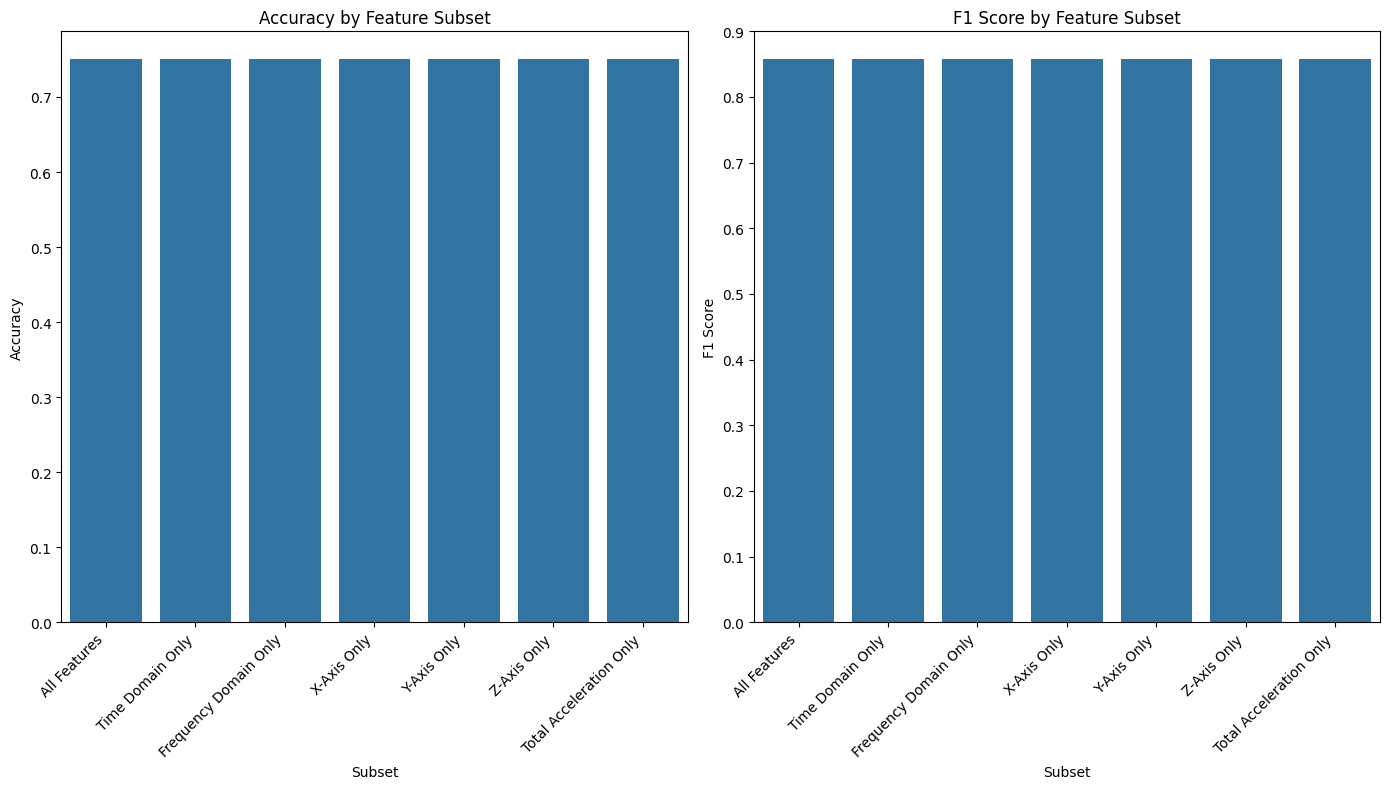